In [ ]:
!pip install transformers
!pip install datasets 
!pip install Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
import torch
import datasets
import numpy as np
import pandas as pd
from datasets import load_dataset
from datasets import DatasetDict
from transformers import GPT2LMHeadModel, GPT2TokenizerFast,AutoConfig
import torch
import torch.nn as nn
from transformers.optimization import Adafactor
import transformers
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import rouge


In [ ]:
raw_datasets = load_dataset("xsum")
train_data = raw_datasets['train']
test_data = raw_datasets['test']

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
raw_datasets = DatasetDict(
    {
        "train": train_data.select(range(500)),
        "test": test_data.select(range(50)),
    }
)

Loading T-5 model

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

Preprocesing the Xsum Dataset to get final input_ids, attention_mask and label 

In [ ]:
prefix_len = 100
def preprocess_function(examples, prefix_len=100, padding=True):
    text_column = 'document'
    summary_column = 'summary'
    max_source_length = 512  
    max_target_length = 512
    text = examples[text_column]
    targets = examples[summary_column]
   

    inputs = " ".join(text.split(' '))[:300]  #for each sample we are only taking 200 words
    inputs = '<|endoftext|>' + inputs + 'TL;DR:' + targets + '<|endoftext|>'
    #tokenize inputs, label and important sentences
    model_inputs = tokenizer(inputs, return_tensors="pt", padding=padding, max_length=max_source_length, truncation=True)
    labels = tokenizer(targets, padding=padding, max_length=max_target_length, return_tensors="pt", truncation=True)
    
    input_length = model_inputs['input_ids'].shape[1]
    target_length = labels["input_ids"].shape[1]

    #print(max_source_length,target_length,prefix_len,input_length)
    #concat input ids with importance sentences in the front and label in the back
    model_inputs['input_ids'] = torch.cat([torch.full((1,prefix_len),1),model_inputs['input_ids'],torch.full((1,max_source_length-prefix_len-input_length), PAD_IDX)],1)
    #print('Input shape',model_inputs['input_ids'].shape)
    #concat label with -100 in the front and padding
    labels["input_ids"] = torch.cat([torch.full((1,prefix_len),-100), labels['input_ids'],torch.full((1,max_target_length-prefix_len-target_length), PAD_IDX)],1)
    model_inputs["labels"] = labels["input_ids"]
    #print(labels['input_ids'].shape)
    #concat attention with 0 in the back
    attention_length = model_inputs["attention_mask"].shape[1]
    model_inputs["attention_mask"] = torch.cat([torch.full((1,prefix_len),1),model_inputs["attention_mask"],torch.full((1,max_source_length-prefix_len-attention_length), 1)],1)

    return model_inputs

In [ ]:
tokenizer.add_special_tokens({'pad_token':'[PAD]'})
PAD_IDX = tokenizer.pad_token_id
PAD_IDX

32100

Loading Xsum Dataset

In [ ]:
column_names = ['document', 'summary','id']
new_train_dataset = raw_datasets["train"].map(lambda example : preprocess_function(example,prefix_len),remove_columns=column_names)
new_test_dataset = raw_datasets["test"].map(lambda example : preprocess_function(example,prefix_len),remove_columns=column_names)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
new_test_dataset = raw_datasets["test"].map(lambda example : preprocess_function(example,prefix_len),remove_columns = [ 'summary','id'])

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
BATCH_SIZE = 8
new_train_dataset.set_format("torch")
loader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE)

In [ ]:
for batch in loader:
  break

In [ ]:
class SoftEmbedding(nn.Module):
    def __init__(self, 
                wte: nn.Embedding,
                n_tokens: int = 10, 
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        """appends learned embedding to 
        Args:
            wte (nn.Embedding): original transformer word embedding
            n_tokens (int, optional): number of tokens for task. Defaults to 10.
            random_range (float, optional): range to init embedding (if not initialize from vocab). Defaults to 0.5.
            initialize_from_vocab (bool, optional): initalizes from default vocab. Defaults to True.
        """
        super(SoftEmbedding, self).__init__()
        self.wte = wte
        self.n_tokens = n_tokens
        self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte,
                                                                                  n_tokens, 
                                                                                  random_range, 
                                                                                  initialize_from_vocab))
            
    def initialize_embedding(self, 
                             wte: nn.Embedding,
                             n_tokens: int = 10, 
                             random_range: float = 0.5, 
                             initialize_from_vocab: bool = True):
        """initializes learned embedding
        Args:
            same as __init__
        Returns:
            torch.float: initialized using original schemes
        """
        if initialize_from_vocab:
            return self.wte.weight[:n_tokens].clone().detach()
        return torch.FloatTensor(n_tokens, wte.weight.size(1)).uniform_(-random_range, random_range)
            
    def forward(self, tokens):
        """run forward pass
        Args:
            tokens (torch.long): input tokens before encoding
        Returns:
            torch.float: encoding of text concatenated with learned task specifc embedding
        """
        input_embedding = self.wte(tokens[:, self.n_tokens:])
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
        return torch.cat([learned_embedding, input_embedding], 1)

T-5 Model parameter Frozen and making Soft Embeeding

In [ ]:
model_setup_for_prompt_tuning=False
if not model_setup_for_prompt_tuning:
  #model.train()

  # Freeze model
  for param in model.parameters():
      param.requires_grad = False

  old_wte = model.get_input_embeddings()

  # Add softembedding module
  s_wte = SoftEmbedding(old_wte,
                        n_tokens=prefix_len,
                        initialize_from_vocab=True).to("cuda")
  model.set_input_embeddings(s_wte)
  if torch.cuda.is_available():
    model = model.cuda()
  # Set up optimizer
  parameters = list(model.parameters())
  # params = [model.transformer.wte.learned_embedding]
  # optimizer = Adafactor(params=params)
  

In [ ]:
optimizer = torch.optim.Adam(s_wte.parameters(), lr=0.5)

Fine-tuning

In [ ]:
import pickle

iterations = 100
name = "100_1_prefix-softprompt_t5"
losses = []
best_loss = float('inf')
for batch in loader:
  for i in range(iterations):
      optimizer.zero_grad()
      input=batch["input_ids"].to("cuda")
      input = input.squeeze(1)
      attention = batch["attention_mask"].to("cuda")
      attention = attention.squeeze(1)
      label = batch["labels"].cuda()
      label = label.squeeze(1)
      output = model(input_ids=input,attention_mask = attention, labels=label)      
      loss = output.loss
      losses.append(loss)
      loss.backward()
      optimizer.step()
      if i%10 == 0:
        print(f"{i}: Loss: {loss}")
  if loss < best_loss:
    best_loss = loss
    #torch.save(model.transformer.wte.learned_embedding, f'{name}.pt')
    pickle.dump(model, open(f"{name}.pkl","wb"))

0: Loss: 43.27168273925781
10: Loss: 24.820026397705078
20: Loss: 20.15635871887207
30: Loss: 16.236495971679688
40: Loss: 9.28208065032959
50: Loss: 5.568653106689453
60: Loss: 4.61680269241333
70: Loss: 4.4377241134643555
80: Loss: 4.28651762008667
90: Loss: 4.1370320320129395
0: Loss: 4.097971439361572
10: Loss: 3.9263389110565186
20: Loss: 3.756643533706665
30: Loss: 3.5896108150482178
40: Loss: 3.420957326889038
50: Loss: 3.2716856002807617
60: Loss: 3.1409032344818115
70: Loss: 3.6327781677246094
80: Loss: 3.268014669418335
90: Loss: 3.0487606525421143
0: Loss: 2.9671273231506348
10: Loss: 2.862494707107544
20: Loss: 2.771711587905884
30: Loss: 2.698455333709717
40: Loss: 2.629931926727295
50: Loss: 2.571446418762207
60: Loss: 2.70235013961792
70: Loss: 2.585148572921753
80: Loss: 2.502110719680786
90: Loss: 2.440685272216797
0: Loss: 2.4316914081573486
10: Loss: 3.700249195098877
20: Loss: 3.988964080810547
30: Loss: 3.8243894577026367
40: Loss: 3.591139316558838
50: Loss: 3.356

In [ ]:
final_losses = [loss.item() for loss in losses]

Loss plot

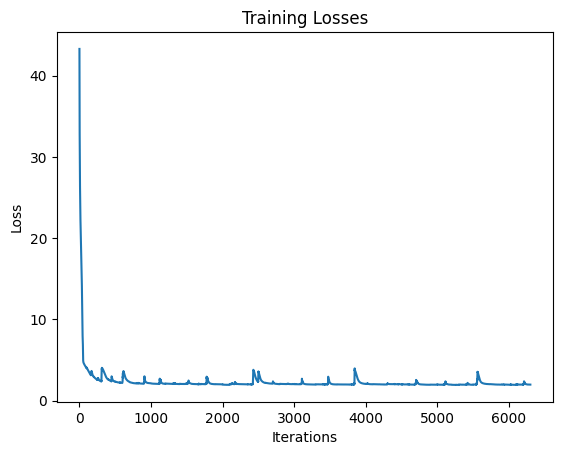

In [ ]:
import matplotlib.pyplot as plt
final_losses = [loss.item() for loss in losses]
# Create a figure and axis object
fig, ax = plt.subplots()

# Create the line plot
ax.plot(final_losses)

# Add a title and axis labels
ax.set_title('Training Losses')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

# Display the plot
plt.show()

In [ ]:
new_test_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 50
})

In [ ]:
new_test_dataset.set_format("pytorch")

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
def top_k_logits(logits, k,topk=0.7):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out
    

Calculating the rouge score from the xsum test dataset

In [ ]:
def get_rouge_score(generated_summary, reference_summary):
  rouge = Rouge()

  # Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores
  scores = rouge.get_scores(generated_summary, reference_summary, avg=True)

  rouge_1_score = scores['rouge-1']['f']
  rouge_2_score = scores['rouge-2']['f']
  rouge_l_score = scores['rouge-l']['f']

  # Print the scores
  #print(f"ROUGE-1 score: {rouge_1_score:.4f}")
  #print(f"ROUGE-2 score: {rouge_2_score:.4f}")
  #print(f"ROUGE-L score: {rouge_l_score:.4f}")
  return [rouge_1_score, rouge_2_score, rouge_l_score]

In [ ]:
from rouge import Rouge
def generate(examples,decoder_input,temperature, output_length = 120):
  model.eval();
  with torch.no_grad():
    tokens = []
    input_ids = examples['input_ids'].cuda()
    #attention_mask = torch.tensor(examples['attention_mask']).cuda()
    summary_ids = input_ids.clone()

    #summary_attention = attention_mask.clone()
    for k in range(output_length):
      logits = model(input_ids=input_ids,decoder_input_ids= decoder_input.cuda()).logits
    
      logits = logits[:, -1, :] / temperature
      logits = top_k_logits(logits, 10)
      probs = F.softmax(logits, dim=-1)   
      next_token = torch.multinomial(probs, num_samples=1)
      while next_token == tokenizer.pad_token_id:
          next_token = torch.multinomial(probs, num_samples=1)
      summary_ids = torch.cat([summary_ids, next_token], dim=1)
      input_ids = summary_ids
      #summary_attention = 
      #attention_mask = torch.cat([attention_mask,torch.full((1,1), 1).cuda()],1).cuda()
    #print(summary_ids)
    summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)
    document = examples['document']
    rouge_score = get_rouge_score(summary, document)
    return {'output_example':summary,'document':document, 'rouge_score':rouge_score}

In [ ]:
decoder_input = tokenizer("Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.\nWorkers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.\nThe Welsh Government said more people than ever were getting help to address housing problems.\nChanges to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.", return_tensors="pt").input_ids  
#res = generate(new_test_dataset[0],decoder_input,0.7,120)

In [ ]:
new_test_dataset.set_format("pytorch")

In [ ]:
temperatures = [0.8]
results = []
for temperature in temperatures:
  results.append(new_test_dataset.map(lambda example:generate(example,decoder_input,temperature,120)))

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
def get_average_rouge_score(scores):
    score_df = pd.DataFrame(scores,columns=['Rouge 1', 'Rouge 2', 'Rouge L'])
    avg = score_df.mean()
    return avg

Final average rouge score

In [ ]:
get_average_rouge_score(results[0]['rouge_score'])

Rouge 1    0.390160
Rouge 2    0.291566
Rouge L    0.384393
dtype: float32